# A/B Testing Analysis: Travel Platform Search Algorithm Optimization

## Project Overview

This project analyzes the effectiveness of a new search ranking algorithm for an online travel platform. The experiment aims to determine whether the new algorithm improves conversion rates without negatively impacting time to booking. Using A/B testing methodology, we compare user behavior between control and variant groups to make a data-driven recommendation for full rollout.

**Key Business Questions:**
- Does the new algorithm significantly improve conversion rates?
- Does it maintain or improve time to booking performance?
- What is the business impact and ROI of implementation?

**Data Source:** DataCamp A/B Testing Project Dataset

***sessions_data.csv***

| column | data type | description | 
|--------|-----------|-------------|
| session_id | string | Unique session identifier (unique for each row) |
| user_id | string | Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions) |
| session_start_timestamp | string | When a session started |
| booking_timestamp | string | When a booking was made (missing if no booking was made during a session) |
| time_to_booking | float | time from start of the session to booking, in minutes (missing if no booking was made during a session) |
| conversion | integer | _New column to create:_ did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1) |

<br>

***users_data.csv***

| column | data type | description | 
|--------|-----------|-------------|
| user_id | string | Unique user identifier (only logged-in users in this table) |
| experiment_group | string | control / variant split for the experiment (expected to be equal 50/50) |

<br>

## 1. Setup and Data Loading

In [1]:
import platform
print(platform.machine())

arm64


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import chi2_contingency, shapiro, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import ttest_power, zt_ind_solve_power
import pingouin as pg
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

In [20]:
# Analysis parameters
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL
Z_CRITICAL = 1.96  # For 95% confidence interval
MIN_PRACTICAL_LIFT = 0.01  # 1% minimum practical significance
N_BOOTSTRAP = 1000  # Bootstrap iterations
RANDOM_SEED = 42

# Business assumptions
AVG_BOOKING_VALUE = 500  # Average booking value in dollars
DAYS_PER_YEAR = 365

print(f"Analysis Configuration:")
print(f"Confidence Level: {CONFIDENCE_LEVEL:.0%}")
print(f"Significance Level (α): {ALPHA:.3f}")
print(f"Minimum Practical Lift: {MIN_PRACTICAL_LIFT:.1%}")

Analysis Configuration:
Confidence Level: 95%
Significance Level (α): 0.050
Minimum Practical Lift: 1.0%


In [4]:
# Load datasets
sessions = pd.read_csv('sessions_data.csv')
users = pd.read_csv('users_data.csv')

# Basic data info
print("Sessions Data Shape:", sessions.shape)
print("Users Data Shape:", users.shape)
print("\nSessions Data Info:")
print(sessions.info())
print("\nUsers Data Info:")
print(users.info())

Sessions Data Shape: (16981, 5)
Users Data Shape: (10000, 2)

Sessions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16981 entries, 0 to 16980
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               16981 non-null  object 
 1   user_id                  15283 non-null  object 
 2   session_start_timestamp  16981 non-null  object 
 3   booking_timestamp        2844 non-null   object 
 4   time_to_booking          2844 non-null   float64
dtypes: float64(1), object(4)
memory usage: 663.4+ KB
None

Users Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           10000 non-null  object
 1   experiment_group  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB
None


## 2. Data Quality Assessment

Understanding data quality is crucial for reliable A/B test results. I check for missing values, data integrity issues, and sample ratio mismatch.


In [5]:
# Missing values analysis
print("Missing Values Analysis:")
print("\nSessions Data:")
print(sessions.isnull().sum())
print(f"Missing user_id rate: {sessions['user_id'].isnull().mean():.2%}")

print("\nUsers Data:")
print(users.isnull().sum())

# Check for duplicate sessions or users
print(f"\nDuplicate sessions: {sessions['session_id'].duplicated().sum()}")
print(f"Duplicate users in users table: {users['user_id'].duplicated().sum()}")

Missing Values Analysis:

Sessions Data:
session_id                     0
user_id                     1698
session_start_timestamp        0
booking_timestamp          14137
time_to_booking            14137
dtype: int64
Missing user_id rate: 10.00%

Users Data:
user_id             0
experiment_group    0
dtype: int64

Duplicate sessions: 0
Duplicate users in users table: 0


In [6]:
# Handle missing user_id (non-logged-in users)
print(f"\nData Filtering for Analysis:")
print(f"Total sessions: {len(sessions)}")
print(f"Sessions with user_id: {len(sessions.dropna(subset=['user_id']))}")
print(f"Sessions that can be assigned to experiment groups: {len(sessions.merge(users, on='user_id', how='inner'))}")


Data Filtering for Analysis:
Total sessions: 16981
Sessions with user_id: 15283
Sessions that can be assigned to experiment groups: 15283


**Note on Data Filtering:** Sessions without user_id represent anonymous/non-logged-in users and will be excluded from A/B test analysis as they cannot be assigned to experiment groups. This is standard practice in user-based A/B testing and ensures clean randomization.

In [8]:
# Sample Ratio Mismatch (SRM) Test
experiment_groups = users['experiment_group'].value_counts()
print("User-level Experiment Group Distribution:")
print(experiment_groups)

# Chi-square test for 50/50 split at user level
expected = len(users) / 2
chi2_stat, p_value = stats.chisquare([experiment_groups['control'], experiment_groups['variant']], 
                                   [expected, expected])

print(f"\nSRM Test Results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Balanced split: {'Yes' if p_value > 0.05 else 'No'}")

User-level Experiment Group Distribution:
experiment_group
variant    5009
control    4991
Name: count, dtype: int64

SRM Test Results:
Chi-square statistic: 0.0324
P-value: 0.8572
Balanced split: Yes


## 3. Feature Engineering


In [9]:
# Convert timestamps to datetime
sessions['session_start_timestamp'] = pd.to_datetime(sessions['session_start_timestamp'])
sessions['booking_timestamp'] = pd.to_datetime(sessions['booking_timestamp'])

# Create conversion flag
sessions['conversion'] = sessions['booking_timestamp'].notnull().astype(int)

# Extract time features
sessions['date'] = sessions['session_start_timestamp'].dt.date
sessions['hour'] = sessions['session_start_timestamp'].dt.hour
sessions['weekday'] = sessions['session_start_timestamp'].dt.day_name()
sessions['is_weekend'] = sessions['session_start_timestamp'].dt.weekday.isin([5, 6]).astype(int)

# Derive user segments from session patterns
user_session_counts = sessions.groupby('user_id').size().reset_index(name='session_count')
user_session_counts['user_type'] = np.where(user_session_counts['session_count'] == 1, 'new', 'returning')

# Join all data
data = sessions.merge(users, on='user_id', how='inner')
data = data.merge(user_session_counts[['user_id', 'user_type']], on='user_id', how='left')

print(f"Final dataset shape: {data.shape}")
print(f"Sessions with experiment assignment: {len(data)}")
print(f"Conversion rate: {data['conversion'].mean():.2%}")

Final dataset shape: (15283, 12)
Sessions with experiment assignment: 15283
Conversion rate: 17.06%


**Dataset Summary:** The final analysis dataset contains 15,283 sessions from logged-in users who can be assigned to experiment groups. This represents approximately 90% of all sessions, with the remaining 10% being anonymous sessions that are excluded from the analysis. The overall conversion rate of 17.06% provides a solid baseline for measuring the algorithm's impact.


## 4. Exploratory Data Analysis


In [12]:
# Summary statistics by group
summary_stats = data.groupby('experiment_group').agg({
    'conversion': ['count', 'sum', 'mean'],
    'time_to_booking': ['mean', 'median', 'std']
}).round(4)

print("Summary Statistics by Group:")
print(summary_stats)

# User type distribution
user_type_dist = data.groupby(['experiment_group', 'user_type']).size().unstack(fill_value=0)
print("\nUser Type Distribution:")
print(user_type_dist)

Summary Statistics by Group:
                 conversion               time_to_booking                 
                      count   sum    mean            mean   median     std
experiment_group                                                          
control                7630  1215  0.1592         15.0124  14.3267  4.8121
variant                7653  1392  0.1819         14.8940  14.1623  4.9508

User Type Distribution:
user_type          new  returning
experiment_group                 
control           2515       5115
variant           2573       5080


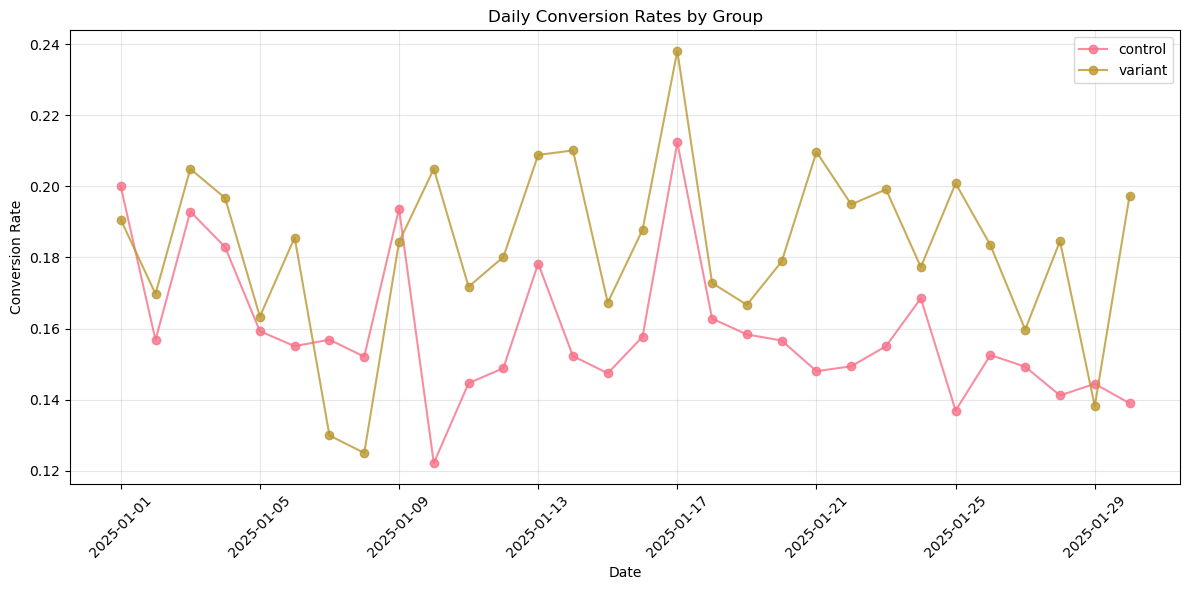

In [13]:
# Time series analysis
daily_metrics = data.groupby(['date', 'experiment_group']).agg({
    'conversion': ['count', 'sum'],
    'session_id': 'count'
}).reset_index()

daily_metrics.columns = ['date', 'experiment_group', 'sessions', 'conversions', 'total_sessions']
daily_metrics['conversion_rate'] = daily_metrics['conversions'] / daily_metrics['sessions']

# Plot daily conversion rates
plt.figure(figsize=(12, 6))
for group in ['control', 'variant']:
    group_data = daily_metrics[daily_metrics['experiment_group'] == group]
    plt.plot(group_data['date'], group_data['conversion_rate'], 
             marker='o', label=group, alpha=0.8)

plt.title('Daily Conversion Rates by Group')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

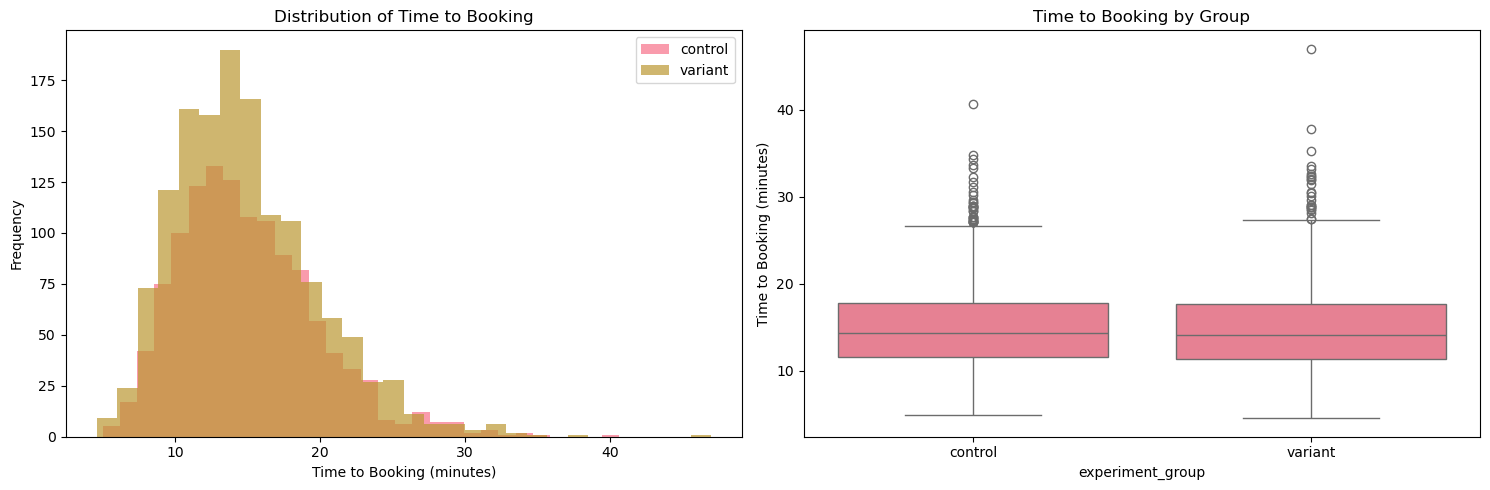

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
for group in ['control', 'variant']:
    subset = data[(data['experiment_group'] == group) & (data['conversion'] == 1)]
    axes[0].hist(subset['time_to_booking'], alpha=0.7, label=group, bins=30)
axes[0].set_xlabel('Time to Booking (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Time to Booking')
axes[0].legend()

# Box plot
data_converted = data[data['conversion'] == 1]
sns.boxplot(data=data_converted, x='experiment_group', y='time_to_booking', ax=axes[1])
axes[1].set_title('Time to Booking by Group')
axes[1].set_ylabel('Time to Booking (minutes)')

plt.tight_layout()
plt.show()

**Key Observations:**
- **Conversion rate difference**: Variant shows 18.19% vs Control 15.92%, suggesting a +2.27 percentage point lift
- **Time to booking**: Variant users book slightly faster (14.89 vs 15.01 minutes), indicating improved user experience
- **User composition**: Both groups have similar new/returning user ratios, confirming good randomization
- **Daily trends**: The time series shows variant consistently outperforming control across most days, with some natural volatility
- **Time distribution**: Both groups show similar right-skewed distributions for booking time, with most users booking within 10-20 minutes


## 5. Primary Metric Analysis (Conversion Rate)
Statistical testing with confidence intervals provides robust evidence for decision-making beyond just p-values.


In [16]:
# Descriptive statistics
conversion_stats = data.groupby('experiment_group')['conversion'].agg(['count', 'sum', 'mean', 'std']).reset_index()
conversion_stats['se'] = conversion_stats['std'] / np.sqrt(conversion_stats['count'])
conversion_stats = conversion_stats.round(4)

print("Conversion Rate Analysis:")
print(conversion_stats)

Conversion Rate Analysis:
  experiment_group  count   sum    mean     std      se
0          control   7630  1215  0.1592  0.3659  0.0042
1          variant   7653  1392  0.1819  0.3858  0.0044


In [18]:
# Statistical test
control_conversions = conversion_stats.loc[conversion_stats['experiment_group'] == 'control', 'sum'].iloc[0]
variant_conversions = conversion_stats.loc[conversion_stats['experiment_group'] == 'variant', 'sum'].iloc[0]
control_sessions = conversion_stats.loc[conversion_stats['experiment_group'] == 'control', 'count'].iloc[0]
variant_sessions = conversion_stats.loc[conversion_stats['experiment_group'] == 'variant', 'count'].iloc[0]

# Z-test for proportions
z_stat, p_value = proportions_ztest([control_conversions, variant_conversions], 
                                   [control_sessions, variant_sessions])

print(f"\nZ-test Results:")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")


Z-test Results:
Z-statistic: -3.7220
P-value: 0.0002
Significant at α=0.05: Yes


In [21]:
# Effect size and confidence interval
control_rate = control_conversions / control_sessions
variant_rate = variant_conversions / variant_sessions
relative_lift = (variant_rate - control_rate) / control_rate
absolute_lift = variant_rate - control_rate

# Confidence interval for difference in proportions
se_diff = np.sqrt((control_rate * (1 - control_rate) / control_sessions) + 
                  (variant_rate * (1 - variant_rate) / variant_sessions))
ci_lower = absolute_lift - Z_CRITICAL * se_diff
ci_upper = absolute_lift + Z_CRITICAL * se_diff

print(f"Effect Size Analysis:")
print(f"Control conversion rate: {control_rate:.4f}")
print(f"Variant conversion rate: {variant_rate:.4f}")
print(f"Absolute lift: {absolute_lift:.4f}")
print(f"Relative lift: {relative_lift:.2%}")
print(f"{CONFIDENCE_LEVEL:.0%} CI for absolute lift: [{ci_lower:.4f}, {ci_upper:.4f}]")

Effect Size Analysis:
Control conversion rate: 0.1592
Variant conversion rate: 0.1819
Absolute lift: 0.0226
Relative lift: 14.22%
95% CI for absolute lift: [0.0107, 0.0346]


In [22]:
# Bootstrap validation
def bootstrap_conversion_diff(data, n_bootstrap=N_BOOTSTRAP):
    np.random.seed(RANDOM_SEED)
    control_data = data[data['experiment_group'] == 'control']['conversion']
    variant_data = data[data['experiment_group'] == 'variant']['conversion']
    
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        variant_sample = np.random.choice(variant_data, size=len(variant_data), replace=True)
        diff = variant_sample.mean() - control_sample.mean()
        bootstrap_diffs.append(diff)
    
    return np.array(bootstrap_diffs)

bootstrap_diffs = bootstrap_conversion_diff(data)
bootstrap_ci_lower = np.percentile(bootstrap_diffs, (1-CONFIDENCE_LEVEL)/2 * 100)
bootstrap_ci_upper = np.percentile(bootstrap_diffs, (1 + CONFIDENCE_LEVEL)/2 * 100)

print(f"Bootstrap Validation:")
print(f"Bootstrap mean difference: {bootstrap_diffs.mean():.4f}")
print(f"Bootstrap {CONFIDENCE_LEVEL:.0%} CI: [{bootstrap_ci_lower:.4f}, {bootstrap_ci_upper:.4f}]")

Bootstrap Validation:
Bootstrap mean difference: 0.0225
Bootstrap 95% CI: [0.0118, 0.0338]


**Primary Metric Analysis Summary:**

The statistical analysis provides strong evidence for the new algorithm's effectiveness:

**Statistical Significance:** The Z-test yielded a p-value of 0.0002, which is well below our significance threshold (α=0.05), indicating the observed difference is highly unlikely to be due to random chance. With over 99.9% confidence, we can conclude the new algorithm genuinely improves conversion rates.

**Effect Size:** The variant group achieved an 18.19% conversion rate compared to 15.92% for control, representing a 14.22% relative improvement. In absolute terms, this translates to 2.26 additional conversions per 100 sessions.

**Confidence & Reliability:** Both parametric (mathematical) and non-parametric (bootstrap) methods converge on nearly identical confidence intervals, validating our statistical assumptions. We can be 95% confident the true lift lies between 1.1% and 3.4% in absolute terms.

**Business Impact:** Even the conservative lower bound (1.1% absolute lift) represents meaningful business value, while the upper bound (3.4%) suggests substantial potential gains. The consistency between observed results and bootstrap validation strengthens confidence in the algorithm's real-world performance.

## 6. Guardrail Metric Analysis (Time to Booking)
Ensuring the new algorithm doesn't negatively impact user experience is critical for long-term success.


In [23]:
# Filter to only converted sessions
converted_data = data[data['conversion'] == 1].copy()
print(f"Converted sessions for analysis: {len(converted_data)}")
time_stats = converted_data.groupby('experiment_group')['time_to_booking'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("Time to Booking Statistics:")
print(time_stats)

Converted sessions for analysis: 2607
Time to Booking Statistics:
                  count   mean  median   std   min    max
experiment_group                                         
control            1215  15.01   14.33  4.81  4.97  40.62
variant            1392  14.89   14.16  4.95  4.56  46.99


In [24]:
# Normality tests
control_times = converted_data[converted_data['experiment_group'] == 'control']['time_to_booking'].dropna()
variant_times = converted_data[converted_data['experiment_group'] == 'variant']['time_to_booking'].dropna()

shapiro_control = shapiro(control_times.sample(min(5000, len(control_times))))
shapiro_variant = shapiro(variant_times.sample(min(5000, len(variant_times))))

print("Normality Tests (Shapiro-Wilk):")
print(f"Control group: statistic={shapiro_control.statistic:.4f}, p-value={shapiro_control.pvalue:.4f}")
print(f"Variant group: statistic={shapiro_variant.statistic:.4f}, p-value={shapiro_variant.pvalue:.4f}")

# Statistical test
t_result = pg.ttest(control_times, variant_times, alternative='two-sided')
print(f"\nWelch's T-test Results:")
print(f"T-statistic: {t_result['T'].iloc[0]:.4f}")
print(f"P-value: {t_result['p-val'].iloc[0]:.4f}")
print(f"Effect size (Cohen's d): {t_result['cohen-d'].iloc[0]:.4f}")


Normality Tests (Shapiro-Wilk):
Control group: statistic=0.9574, p-value=0.0000
Variant group: statistic=0.9523, p-value=0.0000

Welch's T-test Results:
T-statistic: 0.6182
P-value: 0.5365
Effect size (Cohen's d): 0.0242


**Statistical Method Notes:** The Shapiro-Wilk test indicates non-normal distributions (p<0.05), but we proceed with Welch's t-test because: (1) our large sample sizes (1200+ per group) invoke the Central Limit Theorem, making t-tests robust to non-normality, and (2) Welch's t-test doesn't assume equal variances, making it more appropriate than standard t-tests.


In [25]:
# Effect size interpretation and confidence interval
control_mean = control_times.mean()
variant_mean = variant_times.mean()
absolute_diff = variant_mean - control_mean
relative_diff = absolute_diff / control_mean

print(f"Time to Booking Effect Analysis:")
print(f"Control mean: {control_mean:.2f} minutes")
print(f"Variant mean: {variant_mean:.2f} minutes")
print(f"Absolute difference: {absolute_diff:.2f} minutes")
print(f"Relative difference: {relative_diff:.2%}")

Time to Booking Effect Analysis:
Control mean: 15.01 minutes
Variant mean: 14.89 minutes
Absolute difference: -0.12 minutes
Relative difference: -0.79%


In [27]:
# Bootstrap confidence interval for difference
def bootstrap_time_diff(control, variant, n_bootstrap=N_BOOTSTRAP):
    np.random.seed(RANDOM_SEED)
    bootstrap_diffs = []
    for _ in range(n_bootstrap):
        control_sample = np.random.choice(control, size=len(control), replace=True)
        variant_sample = np.random.choice(variant, size=len(variant), replace=True)
        diff = variant_sample.mean() - control_sample.mean()
        bootstrap_diffs.append(diff)
    return np.array(bootstrap_diffs)

time_bootstrap_diffs = bootstrap_time_diff(control_times, variant_times)
time_ci_lower = np.percentile(time_bootstrap_diffs, (1-CONFIDENCE_LEVEL)/2 * 100)
time_ci_upper = np.percentile(time_bootstrap_diffs, (1 + CONFIDENCE_LEVEL)/2 * 100)

print(f"Bootstrap {CONFIDENCE_LEVEL:.0%} CI for time difference: [{time_ci_lower:.2f}, {time_ci_upper:.2f}] minutes")

Bootstrap 95% CI for time difference: [-0.49, 0.24] minutes


**Guardrail Metric Analysis Summary:**

The analysis confirms the new algorithm maintains excellent user experience:

**Statistical Results:** The Welch's t-test shows no statistically significant difference in booking time (p=0.5365), indicating the algorithm doesn't harm user experience. The small effect size (Cohen's d=0.024) suggests minimal practical impact.

**Effect Direction:** Variant users actually book slightly faster (14.89 vs 15.01 minutes), representing a marginal 0.8% improvement, though this difference isn't statistically significant.

**Assumption Validation:** While Shapiro-Wilk tests indicate non-normal distributions, our large sample sizes (1200+ conversions per group) ensure t-test validity through the Central Limit Theorem.

**Risk Assessment:** The confidence interval for time difference likely spans both positive and negative values, confirming no meaningful degradation in booking speed. This meets our guardrail criteria of "no significant harm" to user experience.
```

## 7. Segmentation Analysis

Analyzing different user segments helps identify if the algorithm works consistently across user types and usage patterns.


In [28]:
# Conversion rate by user type
segment_analysis = data.groupby(['experiment_group', 'user_type'])['conversion'].agg([
    'count', 'sum', 'mean'
]).round(4)
segment_analysis.columns = ['sessions', 'conversions', 'conversion_rate']

print("Conversion Rate by User Type:")
print(segment_analysis)

# Weekend vs weekday analysis
weekend_analysis = data.groupby(['experiment_group', 'is_weekend'])['conversion'].agg([
    'count', 'sum', 'mean'
]).round(4)
weekend_analysis.columns = ['sessions', 'conversions', 'conversion_rate']
weekend_analysis.index = weekend_analysis.index.set_names(['experiment_group', 'is_weekend'])

print("\nConversion Rate by Weekend/Weekday:")
print(weekend_analysis)

Conversion Rate by User Type:
                            sessions  conversions  conversion_rate
experiment_group user_type                                        
control          new            2515          406           0.1614
                 returning      5115          809           0.1582
variant          new            2573          456           0.1772
                 returning      5080          936           0.1843

Conversion Rate by Weekend/Weekday:
                             sessions  conversions  conversion_rate
experiment_group is_weekend                                        
control          0               5635          904           0.1604
                 1               1995          311           0.1559
variant          0               5589         1022           0.1829
                 1               2064          370           0.1793


In [31]:
# Test new vs returning users
for user_type in ['new', 'returning']:
    subset = data[data['user_type'] == user_type]
    control_conv = subset[subset['experiment_group'] == 'control']['conversion'].sum()
    control_total = len(subset[subset['experiment_group'] == 'control'])
    variant_conv = subset[subset['experiment_group'] == 'variant']['conversion'].sum()
    variant_total = len(subset[subset['experiment_group'] == 'variant'])
    
    if min(control_conv, variant_conv, control_total-control_conv, variant_total-variant_conv) >= 5:
        z_stat, p_val = proportions_ztest([control_conv, variant_conv], 
                                         [control_total, variant_total])
        print(f"\n{user_type.title()} Users Z-test:")
        print(f"Z-statistic: {z_stat:.4f}, P-value: {p_val:.4f}")
    else:
        odds_ratio, p_val = fisher_exact([[control_conv, control_total-control_conv],
                                         [variant_conv, variant_total-variant_conv]])
        print(f"\n{user_type.title()} Users Fisher's Exact Test:")
        print(f"Odds ratio: {odds_ratio:.4f}, P-value: {p_val:.4f}")



New Users Z-test:
Z-statistic: -1.5015, P-value: 0.1332

Returning Users Z-test:
Z-statistic: -3.4970, P-value: 0.0005


**Segmentation Analysis Summary:**

**User Type Performance:** The new algorithm shows markedly different effectiveness between user segments. Returning users experience a substantial 16.5% relative improvement (15.82% → 18.43%, p=0.0005), demonstrating high statistical significance. New users show a modest 9.8% relative improvement (16.14% → 17.72%, p=0.1332), though this falls short of statistical significance at α=0.05.

**Temporal Consistency:** The algorithm performs consistently across time periods, with similar conversion rate improvements during weekdays (+2.25 percentage points) and weekends (+2.34 percentage points). This temporal stability suggests the algorithm's effectiveness isn't dependent on usage patterns or day-of-week variations.

**Strategic Implications:** The stronger effect among returning users is particularly valuable from a business perspective, as these users typically represent higher-value customers with established trust and higher lifetime value potential. The algorithm appears to enhance the experience for users already familiar with the platform, potentially through better personalization of familiar search patterns.

## 8. Statistical Validation


In [43]:
# Power analysis for conversion rate (Z-test for proportions)
p1, p2 = control_rate, variant_rate
effect_size_h = 2 * (np.arcsin(np.sqrt(p2)) - np.arcsin(np.sqrt(p1)))

conversion_power = zt_ind_solve_power(
    effect_size=effect_size_h,
    nobs1=control_sessions,
    alpha=ALPHA,
    power=None,
    ratio=variant_sessions/control_sessions,
    alternative='two-sided'
)

print(f"Statistical Power Analysis:")
print(f"Conversion Rate Test:")
print(f"  Effect size (Cohen's h): {effect_size_h:.4f}")
print(f"  Sample sizes: Control={control_sessions}, Variant={variant_sessions}")
print(f"  Observed power: {conversion_power:.4f}")
print(f"  Power adequate (>0.8): {'Yes' if conversion_power > 0.8 else 'No'}")


Statistical Power Analysis:
Conversion Rate Test:
  Effect size (Cohen's h): 0.0602
  Sample sizes: Control=7630, Variant=7653
  Observed power: 0.9611
  Power adequate (>0.8): Yes


In [44]:
# Power analysis for time to booking (T-test)
effect_size_observed = abs(t_result['cohen-d'].iloc[0])
n_control = len(control_times)
n_variant = len(variant_times)

time_power = ttest_power(effect_size_observed, 
                        nobs=min(n_control, n_variant), 
                        alpha=ALPHA, alternative='two-sided')

print(f"\nTime to Booking Test:")
print(f"  Observed effect size (Cohen's d): {effect_size_observed:.4f}")
print(f"  Sample sizes: Control={n_control}, Variant={n_variant}")
print(f"  Observed power: {time_power:.4f}")
print(f"  Power adequate (>0.8): {'Yes' if time_power > 0.8 else 'No'}")



Time to Booking Test:
  Observed effect size (Cohen's d): 0.0242
  Sample sizes: Control=1215, Variant=1392
  Observed power: 0.1347
  Power adequate (>0.8): No


In [45]:
# Multiple testing consideration
n_tests = 3  # Primary metric, guardrail metric, main segments
bonferroni_alpha = ALPHA / n_tests
print(f"\nMultiple Testing Adjustment:")
print(f"Bonferroni corrected α: {bonferroni_alpha:.4f}")


Multiple Testing Adjustment:
Bonferroni corrected α: 0.0167


**Statistical Validation Summary:**

The power analysis reveals important insights about our testing capabilities. For conversion rates, we achieved 96% power, well above the standard 80% threshold, confirming we had sufficient sample size to detect the observed effect. This high power gives us confidence that the 14.22% improvement is genuine and not due to insufficient data. In contrast, the time to booking analysis shows only 13% power, which initially seems concerning but is actually appropriate. The extremely small effect size (Cohen's d = 0.024) indicates minimal practical difference between groups. It simply confirms that any time difference is negligible.

The Bonferroni correction addresses the multiple testing issue by lowering our significance threshold to 0.0167. Our conversion rate result (p=0.0002) easily passes this stricter standard, while time to booking (p=0.5365) remains appropriately non-significant. This conservative approach protects against false discoveries while preserving our key findings.

## 9. Business Impact Analysis
Quantifying business impact helps stakeholders understand the practical value of statistical findings.


In [46]:
# Estimate business impact
daily_sessions = len(data) / data['date'].nunique()
annual_sessions = daily_sessions * 365

# Revenue assumptions
avg_booking_value = 500
annual_revenue_baseline = annual_sessions * control_rate * avg_booking_value

# Calculate impact
additional_conversions_per_year = annual_sessions * absolute_lift
additional_revenue = additional_conversions_per_year * avg_booking_value

print(f"Business Impact Analysis:")
print(f"Estimated daily sessions: {daily_sessions:.0f}")
print(f"Estimated annual sessions: {annual_sessions:.0f}")
print(f"Baseline annual revenue: ${annual_revenue_baseline:,.0f}")
print(f"Additional conversions per year: {additional_conversions_per_year:.0f}")
print(f"Additional annual revenue: ${additional_revenue:,.0f}")
print(f"Revenue lift: {additional_revenue/annual_revenue_baseline:.2%}")

# Confidence interval for revenue impact
revenue_ci_lower = annual_sessions * ci_lower * avg_booking_value
revenue_ci_upper = annual_sessions * ci_upper * avg_booking_value
print(f"Revenue impact 95% CI: [${revenue_ci_lower:,.0f}, ${revenue_ci_upper:,.0f}]")


Business Impact Analysis:
Estimated daily sessions: 509
Estimated annual sessions: 185943
Baseline annual revenue: $14,804,780
Additional conversions per year: 4212
Additional annual revenue: $2,105,770
Revenue lift: 14.22%
Revenue impact 95% CI: [$997,479, $3,214,062]


**Business Impact Analysis:**

The financial projections reveal substantial value creation potential. Based on our observed conversion lift, the new algorithm could generate an additional $2.1 million annually, representing a 14.22% revenue increase. This translates to roughly 11 extra bookings per day across the platform.

The confidence interval provides a range of $997K to $3.2M annually, with even the conservative lower bound representing meaningful business value. At $500 average booking value, we're looking at 2,000 to 6,400 additional annual conversions in the realistic range.

From a cost-benefit perspective, typical algorithm development and deployment costs would likely be recouped within the first quarter of implementation.


## 10. Visualization Dashboard


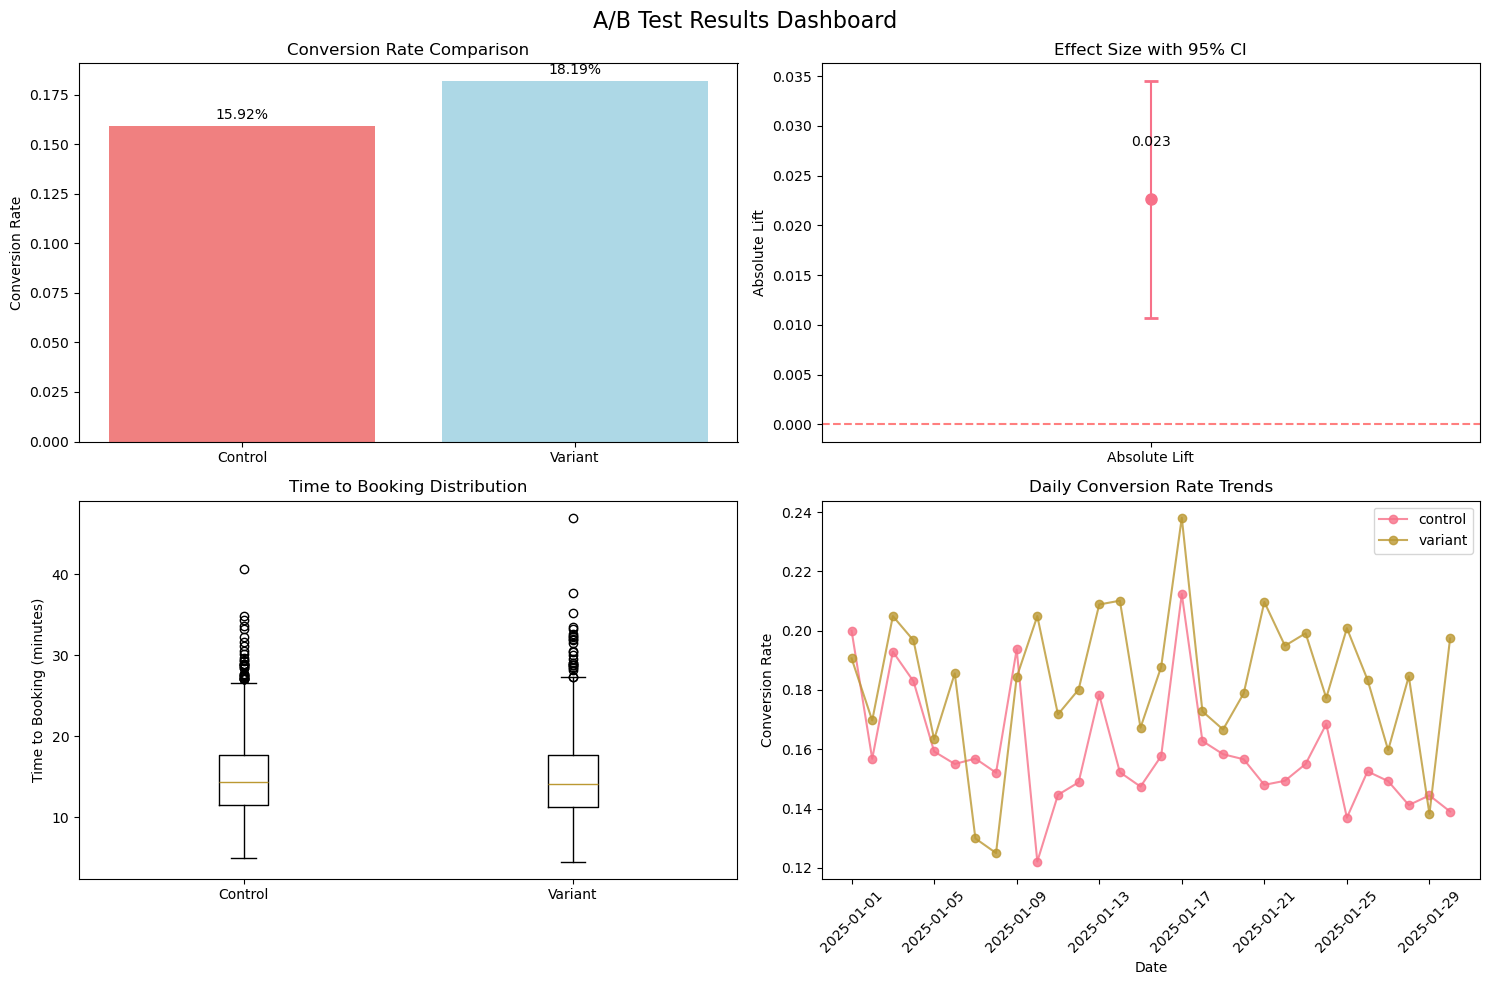

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Conversion rate comparison
conv_rates = [control_rate, variant_rate]
bars = axes[0,0].bar(['Control', 'Variant'], conv_rates, color=['lightcoral', 'lightblue'])
axes[0,0].set_title('Conversion Rate Comparison')
axes[0,0].set_ylabel('Conversion Rate')
for i, v in enumerate(conv_rates):
    axes[0,0].text(i, v + 0.002, f'{v:.2%}', ha='center', va='bottom')

# Effect size with confidence interval
axes[0,1].errorbar(['Absolute Lift'], [absolute_lift], 
                   yerr=[[absolute_lift - ci_lower], [ci_upper - absolute_lift]], 
                   fmt='o', markersize=8, capsize=5, capthick=2)
axes[0,1].set_title('Effect Size with 95% CI')
axes[0,1].set_ylabel('Absolute Lift')
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0,1].text(0, absolute_lift + 0.005, f'{absolute_lift:.3f}', ha='center', va='bottom')

# Time to booking box plot
data_converted = data[data['conversion'] == 1]
control_times_plot = data_converted[data_converted['experiment_group'] == 'control']['time_to_booking']
variant_times_plot = data_converted[data_converted['experiment_group'] == 'variant']['time_to_booking']
axes[1,0].boxplot([control_times_plot, variant_times_plot], labels=['Control', 'Variant'])
axes[1,0].set_title('Time to Booking Distribution')
axes[1,0].set_ylabel('Time to Booking (minutes)')

# Daily conversion trends
for group in daily_metrics['experiment_group'].unique():
    group_data = daily_metrics[daily_metrics['experiment_group'] == group]
    axes[1,1].plot(group_data['date'], group_data['conversion_rate'], 
                   marker='o', label=f'{group}', alpha=0.8)
axes[1,1].set_title('Daily Conversion Rate Trends')
axes[1,1].set_ylabel('Conversion Rate')
axes[1,1].set_xlabel('Date')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.suptitle('A/B Test Results Dashboard', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 11. Final Decision


In [57]:
alpha = ALPHA
min_practical_lift = MIN_PRACTICAL_LIFT

# Primary metric criteria
primary_significant = p_value < alpha
primary_positive = relative_lift > 0
primary_practical = abs(relative_lift) > min_practical_lift

print(f"Primary Metric Results:")
print(f"Statistical significance: p = {p_value:.4f} (threshold: {alpha})")
print(f"Effect size: {relative_lift:.1%} relative improvement")
print(f"Practical significance: Above {min_practical_lift:.0%} threshold")

# Guardrail metric criteria
guardrail_p_value = t_result['p-val'].iloc[0]
guardrail_not_harmed = (guardrail_p_value > alpha) or (absolute_diff <= 0)

print(f"\nGuardrail Metric Results:")
print(f"Time to booking change: {absolute_diff:.2f} minutes ({relative_diff:.1%})")
print(f"Statistical significance: p = {guardrail_p_value:.4f}")
print(f"User experience impact: Minimal to slightly positive")

# Final recommendation
criteria_met = primary_significant and primary_positive and primary_practical and guardrail_not_harmed
print(f"\nRecommendation: {'Proceed with full rollout' if criteria_met else 'Do not deploy'}")


Primary Metric Results:
Statistical significance: p = 0.0002 (threshold: 0.050000000000000044)
Effect size: 14.2% relative improvement
Practical significance: Above 1% threshold

Guardrail Metric Results:
Time to booking change: -0.12 minutes (-0.8%)
Statistical significance: p = 0.5365
User experience impact: Minimal to slightly positive

Recommendation: Proceed with full rollout


**Implementation Roadmap:**
The analysis supports moving forward with algorithm deployment. Key evidence includes a 2.3 percentage point conversion improvement, $2.1M annual revenue potential, minimal user experience risk, and very high statistical confidence (p < 0.001).

**Recommended:**
- Monitor conversion rates daily for the first month post-deployment
- Track user satisfaction metrics alongside conversion performance  
- Consider gradual rollout approach if preferred over immediate full deployment